In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch
from torch import nn as nn
from torch.nn import MSELoss
import torch.nn.functional as F
import torchmetrics
from torchmetrics import MeanSquaredError,PearsonCorrCoef
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric --no-index --find-links=file:///kaggle/input/torch-geometric
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data,Dataset
from torch_geometric.nn import GCNConv, GATConv,global_mean_pool
from torch_geometric.nn.norm import BatchNorm
from torch.optim.lr_scheduler import StepLR,ExponentialLR
from torchmetrics import R2Score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import os
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Looking in links: file:///kaggle/input/torch-geometric
Processing /kaggle/input/torch-geometric/torch_scatter-2.1.0-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_sparse-0.6.16-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_cluster-1.6.0-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_spline_conv-1.2.1-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_geometric-2.2.0-py3-none-any.whl


In [2]:
dataset=[]
for i in range(0,400):
    dataset.append(torch.load("/kaggle/input/bapst-data-static-structure-in-glasses/graphs/graph"+str(i)+".pt"))
    dataset[i].x=dataset[i].x.type(torch.float32)
    dataset[i].edge_attr=dataset[i].edge_attr.type(torch.float32)

In [3]:
train_loader=DataLoader(dataset[:350],batch_size=20,shuffle=True)
test_loader=DataLoader(dataset[350:],batch_size=20,shuffle=True)

In [4]:
device

device(type='cuda')

In [5]:
dataset[0]

Data(x=[4096, 1], edge_index=[2, 167710], edge_attr=[167710, 3], y=[4096, 1], pos=[4096, 3], e_pot=0, pair_pot=0, edge_targets=[167710, 1], delta_r_cage=[4096, 1])

In [6]:
dataset[0].edge_index

tensor([[   0,    0,    0,  ..., 4095, 4095, 4095],
        [3992,  361, 2985,  ..., 3200,  408,  407]])

In [7]:
dataset[0].edge_index.shape

torch.Size([2, 167710])

In [8]:
dataset[0].edge_attr

tensor([[ 0.8492,  0.3198,  0.1136],
        [-0.3012,  0.9385,  0.1335],
        [-0.6697, -0.6789, -0.2953],
        ...,
        [ 0.8370,  0.7992, -1.5461],
        [ 1.7959,  0.0975,  0.8138],
        [ 1.2470, -1.4115, -0.5917]])

In [9]:
dataset[0].edge_attr.shape

torch.Size([167710, 3])

In [14]:
pearson_correr=PearsonCorrCoef().to(device)
r2_scorer=R2Score().to(device)

In [15]:
def evaluate():
    model.eval()
    outs=torch.empty(0).to(device)
    ys=torch.empty(0).to(device)
    for data in test_loader:
        data=data.to(device)
        out=model(data)
        outs=torch.cat((outs,out.flatten()))
        ys=torch.cat((ys,data.y.flatten()))
        #data.cpu()
    pearson=pearson_correr(outs,ys)
    r2=r2_scorer(outs,ys)
    return pearson.item(),r2.item()

In [16]:
class GATCONVModel(torch.nn.Module):
    def __init__(self,hidden_dim=6,attention_heads=3,dropout_rate=0.0):
        super(GATCONVModel,self).__init__()
        torch.manual_seed(46)
        self.conv1=GATConv(1,hidden_dim,heads=attention_heads,dropout=dropout_rate,edge_dim=3)
        self.conv2=GATConv(hidden_dim*attention_heads,hidden_dim,heads=attention_heads,dropout=dropout_rate,edge_dim=3)
        self.lin=nn.Linear(hidden_dim*attention_heads,1)
        
    def forward(self,data):
        x,edge_index,edge_attr=data.x,data.edge_index,data.edge_attr
        x=self.conv1(x,edge_index,edge_attr)
        x=self.conv2(x,edge_index,edge_attr)
        x=self.lin(x)
        return x

In [17]:
loss_fn=MSELoss()
model=GATCONVModel().to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=0.01,weight_decay=5e-6)
scheduler = StepLR(optimizer,step_size=60, gamma=0.1)
train_losses=[]
test_losses=[]
for epoch in range(150):
    if epoch%1==0 and epoch!=0:
        print("epoch:",epoch,"| loss:",train_losses[-1]," | pearson_corr:",evaluate()[0]," | r2_score:",evaluate()[1])
    batch_losses=[]
    model.train()
    for data in train_loader:
        data=data.to(device)
        optimizer.zero_grad()
        out=model(data)
        loss=loss_fn(out,data.y)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    train_losses.append(np.mean(batch_losses))
    
    model.eval()
    batch_losses=[]
    for data in test_loader:
        data=data.to(device)
        out=model(data)
        loss=loss_fn(out,data.y)
        batch_losses.append(loss.item())
    test_losses.append(np.mean(batch_losses))

epoch: 1 | loss: 0.2637075372040272  | pearson_corr: -0.10685624927282333  | r2_score: -0.19390666484832764
epoch: 2 | loss: 0.11028022774391705  | pearson_corr: -0.0790526419878006  | r2_score: -0.04598236083984375
epoch: 3 | loss: 0.09820235561993387  | pearson_corr: -0.023770207539200783  | r2_score: -0.02687835693359375
epoch: 4 | loss: 0.09539988802538978  | pearson_corr: 0.12024630606174469  | r2_score: 0.013577103614807129
epoch: 5 | loss: 0.09004646953609255  | pearson_corr: 0.30797189474105835  | r2_score: 0.09470337629318237
epoch: 6 | loss: 0.08476764129267798  | pearson_corr: 0.34716346859931946  | r2_score: 0.11530625820159912
epoch: 7 | loss: 0.08323715875546138  | pearson_corr: 0.3561651408672333  | r2_score: 0.1260831356048584
epoch: 8 | loss: 0.08217545226216316  | pearson_corr: 0.3652086555957794  | r2_score: 0.13246065378189087
epoch: 9 | loss: 0.08180185159047444  | pearson_corr: 0.3707295358181  | r2_score: 0.1371767520904541
epoch: 10 | loss: 0.08181307133701113  

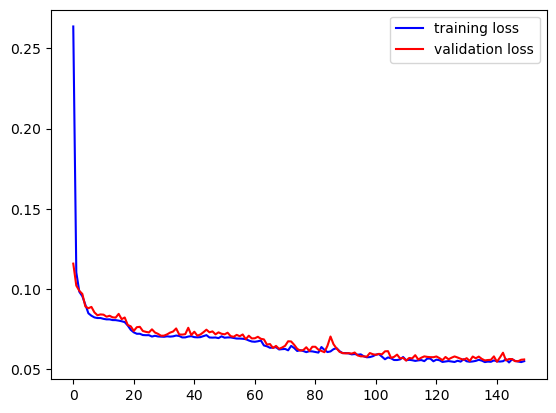

In [18]:
plt.plot(train_losses,color='blue')
plt.plot(test_losses,color='red')
plt.legend(["training loss","validation loss"])
plt.show()